# Plot Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [10]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run "utils/compound.ipynb"

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [5]:
firePos=xarray.open_dataarray('results/cesmFirePos.nc')

fireNeg=xarray.open_dataarray('results/cesmFireNeg.nc')

# In non-overlapping 30 year bins

Calculate non-overlapping 30 year bins, and sum the number of events in them

In [6]:
yearBins=numpy.arange(860, 2100, 30)

binMid=numpy.arange(875, 2086, 30)

binnedFirePos=firePos.groupby_bins('year', yearBins, labels=binMid ).sum() 

binnedFirePos= binnedFirePos.rename({'year_bins':'year'})


Plot the mean in each bin for the full forcing ensemble and the rcp85 extensions

In [7]:
pairs=firePos.attrs['pairs']
toPlot=[*pairs,'all3']
colors=['orange', 'purple', 'green','blue']

def binPlot(da, expSet):

    plt.figure(figsize=(18,6))

    for counter in [0,1,2,3]:
        plt.vlines(
            x=da.year-3+1.5*counter, 
            ymin=0,
            ymax=da.sel(index=toPlot[counter], experiment=expSet).mean(dim='experiment'),
            label=toPlot[counter],
            color=colors[counter]
        )

    plt.legend(loc='upper left')
    plt.xticks(ticks=da.year)
    plt.xlim(1700,2100)
    plt.xlabel('Mid-point of 30 year bin')
    plt.ylim(0,8)
    plt.ylabel('Number of events (mean)')
    plt.title('Pairs and all-three for runs with ' + str(expSet) + ', in non-overlaping 30 year bins')
    plt.minorticks_on()

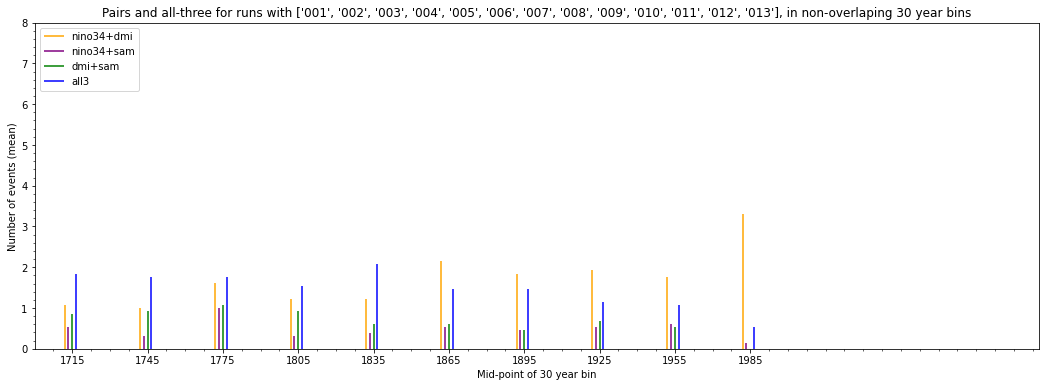

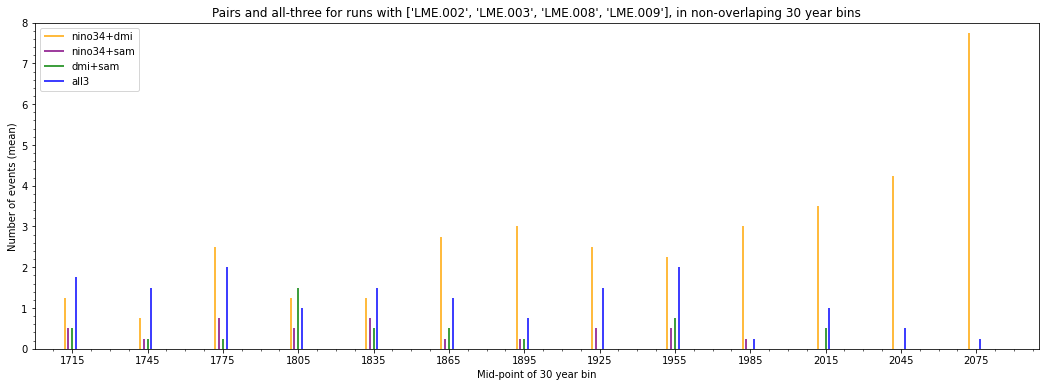

In [8]:
binPlot(binnedFirePos.where(binnedFirePos.year<=1985, drop=True), _model.cesmFullForcings)

binPlot(binnedFirePos, _model.cesmRcp85)

# In overlapping 30 year bins

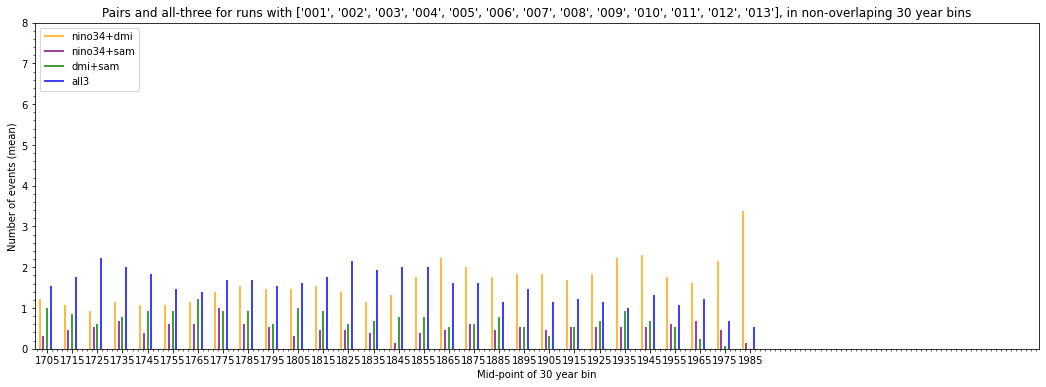

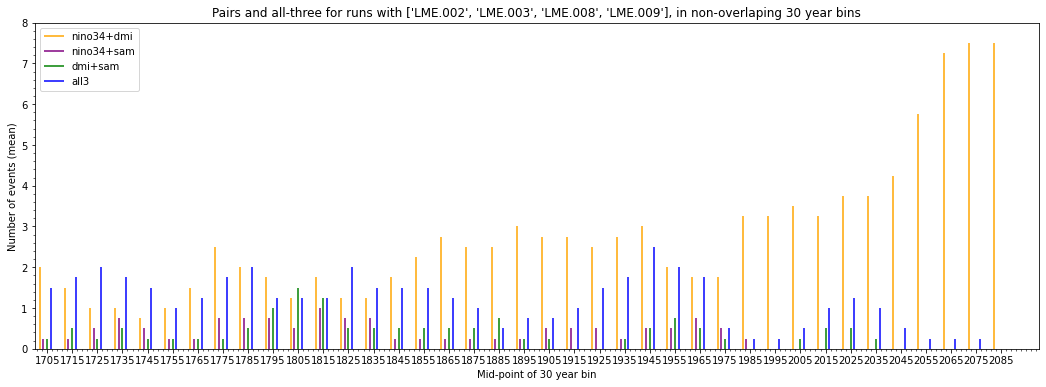

In [11]:
overBinFirePos = overlappingBinSum(firePos)

binPlot(overBinFirePos.where(overBinFirePos.year<=1985, drop=True), _model.cesmFullForcings)

binPlot(overBinFirePos, _model.cesmRcp85)